In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve


from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [ ]:
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676.0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,NaN,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182.0,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665.0,Female,79.0,1,0,NaN,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
data.shape

(5110, 12)

In [ ]:
data.isnull().sum()

id                    87
gender                10
age                    3
hypertension           0
heart_disease          0
ever_married          10
work_type              0
Residence_type        10
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
data.drop(columns=['id'], inplace=True)

In [ ]:
data['bmi'].replace(np.nan, data['bmi'].mean(), inplace=True)

In [ ]:
data.dropna(subset=["gender","age","ever_married","Residence_type"], inplace=True)

In [ ]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [ ]:
discrete_features = []
categorical_features = []

for i in list(data.columns):
    if len(data[i].unique()) > 6:
        discrete_features.append(i)
    else:
        categorical_features.append(i)

print("Discrete Features:")
print(discrete_features)
print("\nCategorical Features:")
print(categorical_features)

data1 = data.copy(deep=True)

Discrete Features:
['age', 'avg_glucose_level', 'bmi']

Categorical Features:
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']


In [ ]:
# For 'gender'
gender_stroke = data[data['stroke'] == 1]['gender'].value_counts(normalize=True) * 100

# For 'hypertension'
hypertension_stroke = data[data['stroke'] == 1]['hypertension'].value_counts(normalize=True) * 100

# For 'heart_disease'
heart_disease_stroke = data[data['stroke'] == 1]['heart_disease'].value_counts(normalize=True) * 100

# For 'ever_married'
ever_married_stroke = data[data['stroke'] == 1]['ever_married'].value_counts(normalize=True) * 100

# For 'work_type'
work_type_stroke = data[data['stroke'] == 1]['work_type'].value_counts(normalize=True) * 100


In [ ]:
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.000000,formerly smoked,1


In [ ]:
#creating Target and feature variables
X_target = np.where(data['stroke'].shift(-1) > data['stroke'], 0, 1)
Y_features = data[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','age', 'avg_glucose_level', 'bmi']].values

In [ ]:
le = LabelEncoder()
text_cols = list(data1.select_dtypes(include=['object']).columns)


l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_cols):
    data1[i] = le.fit_transform(data1[i])
    l3.append(list(data1[i].unique())); l4.append(list(le.inverse_transform(data1[i].unique())))
    print(i,' : ',data1[i].unique(),' = ',le.inverse_transform(data1[i].unique()))




Label Encoder Transformation


100%|██████████| 5/5 [00:00<00:00, 174.77it/s]

gender  :  [1 0 2]  =  ['Male' 'Female' 'Other']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
tf1 = {}
for i in range(len(text_cols)):
    tf1[text_cols[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf1[text_cols[i]][j] = k

tf1['hypertension'] = {0 : 'No Hypertension', 1 : 'Hypertension'}
tf1['heart_disease'] = {0 : 'No Heart Disease', 1 : 'Heart Disease'}
tf1

{'gender': {1: 'Male', 0: 'Female', 2: 'Other'},
 'ever_married': {1: 'Yes', 0: 'No'},
 'work_type': {2: 'Private',
  3: 'Self-employed',
  0: 'Govt_job',
  4: 'children',
  1: 'Never_worked'},
 'Residence_type': {1: 'Urban', 0: 'Rural'},
 'smoking_status': {1: 'formerly smoked',
  2: 'never smoked',
  3: 'smokes',
  0: 'Unknown'},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

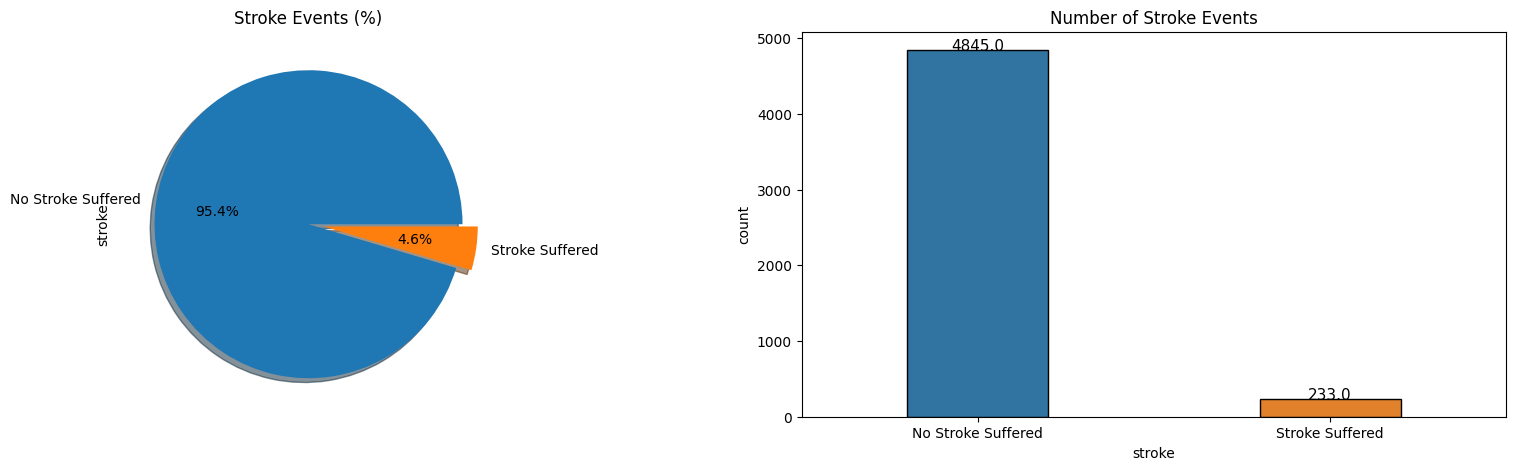

In [ ]:
l = data['stroke'].value_counts()

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
l.plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True, labels=['No Stroke Suffered','Stroke Suffered'])
plt.title('Stroke Events (%)')


plt.subplot(1,2,2)
ax = sns.countplot(x='stroke',data = data1,edgecolor = 'black', width=0.4)
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['No Stroke Suffered','Stroke Suffered'])
plt.title('Number of Stroke Events')
plt.show()

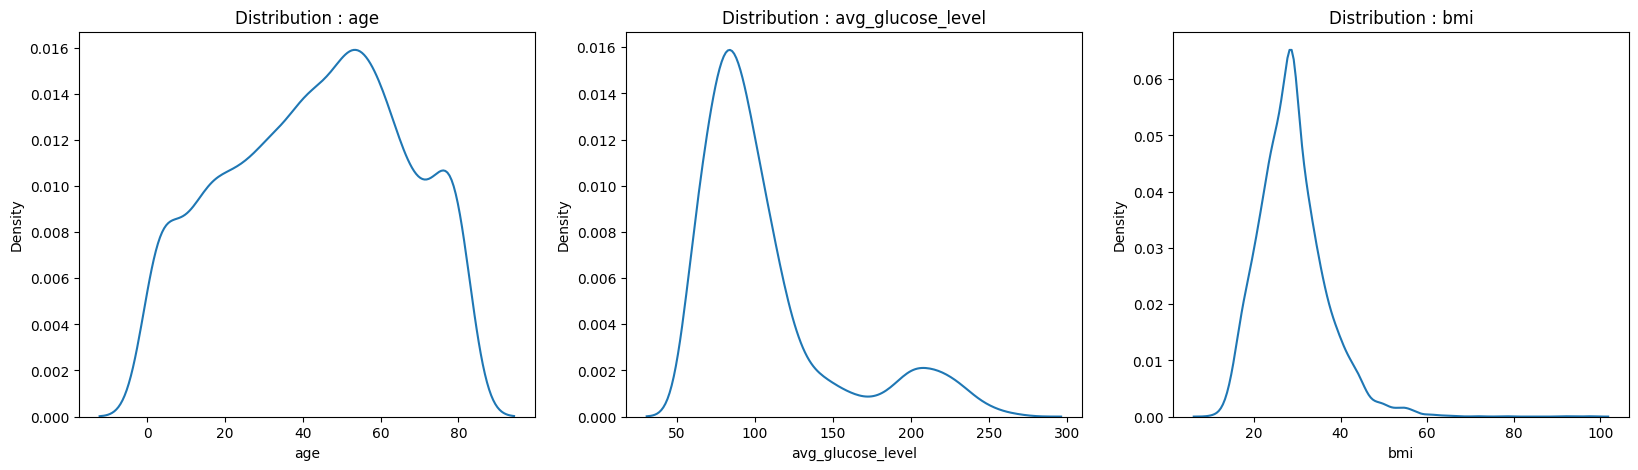

In [ ]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    sns.kdeplot(data1[discrete_features[i]])
    title = 'Distribution : ' + discrete_features[i]
    plt.title(title)
plt.show()

ValueError: ignored

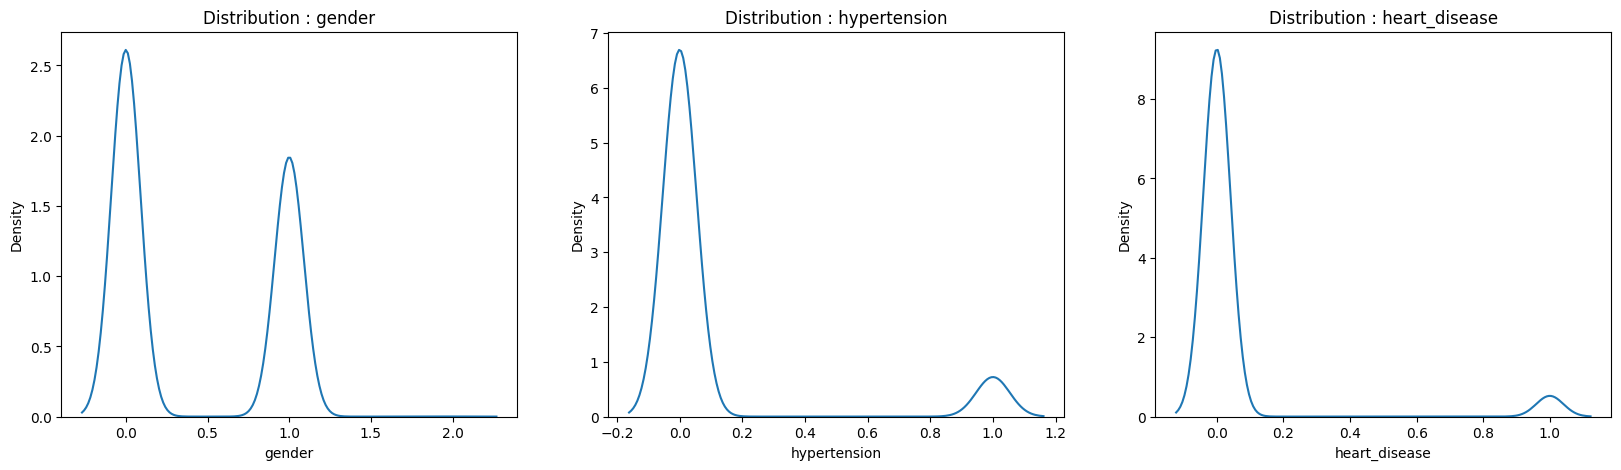

In [ ]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5))
for i in range(len(categorical_features)):
    plt.subplot(1,3,i+1)
    sns.kdeplot(data1[categorical_features[i]])
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)
plt.show()

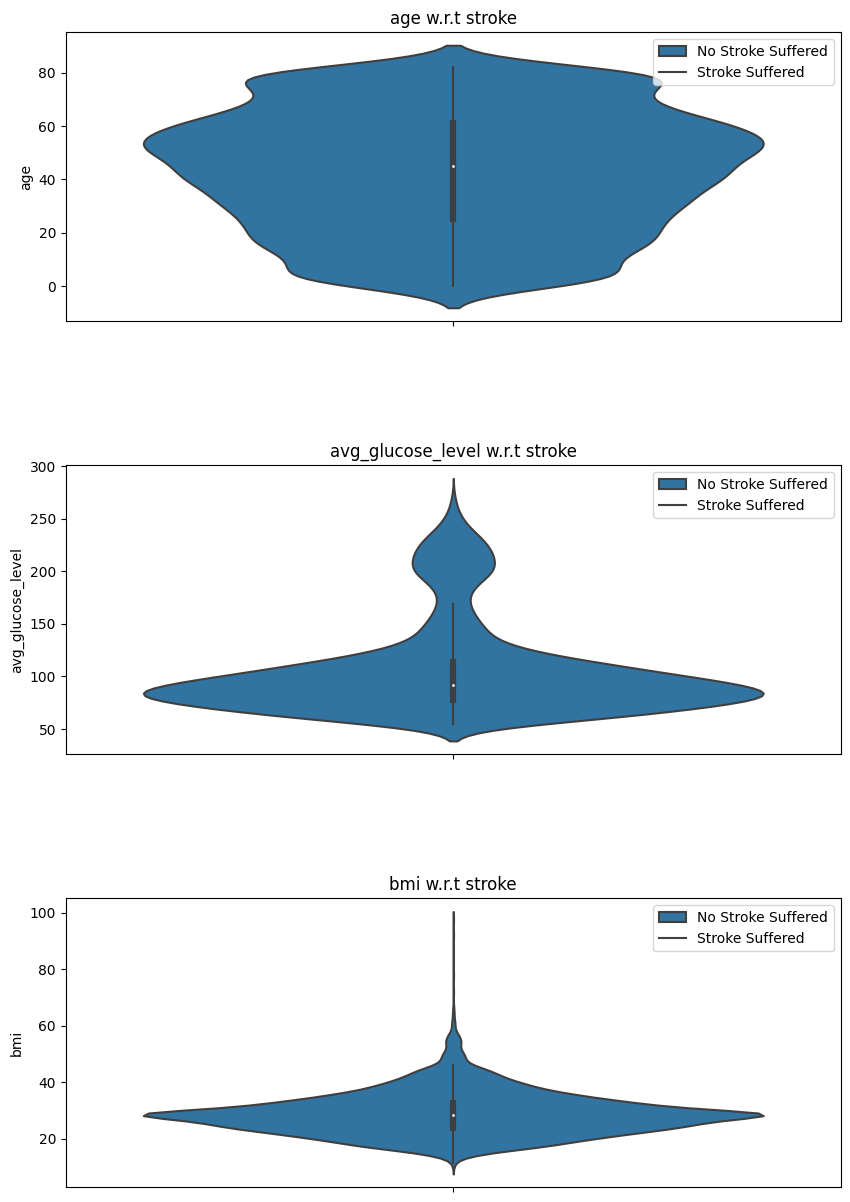

In [ ]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (10,15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(len(discrete_features)):
    plt.subplot(3,1,i+1)
    sns.violinplot(y=discrete_features[i],data = data1,hue = "stroke",edgecolor = 'black')
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'] ,loc = 'upper right')
    title = discrete_features[i] + ' w.r.t stroke'
    plt.title(title)

In [ ]:
data1['age_group'] = [ int(i / 5) for i in data1['age']]
data1['avg_glucose_level_group'] = [ int(i / 20) for i in data1['avg_glucose_level']]
data1['bmi_group'] = [ int(i / 5) for i in data1['bmi']]

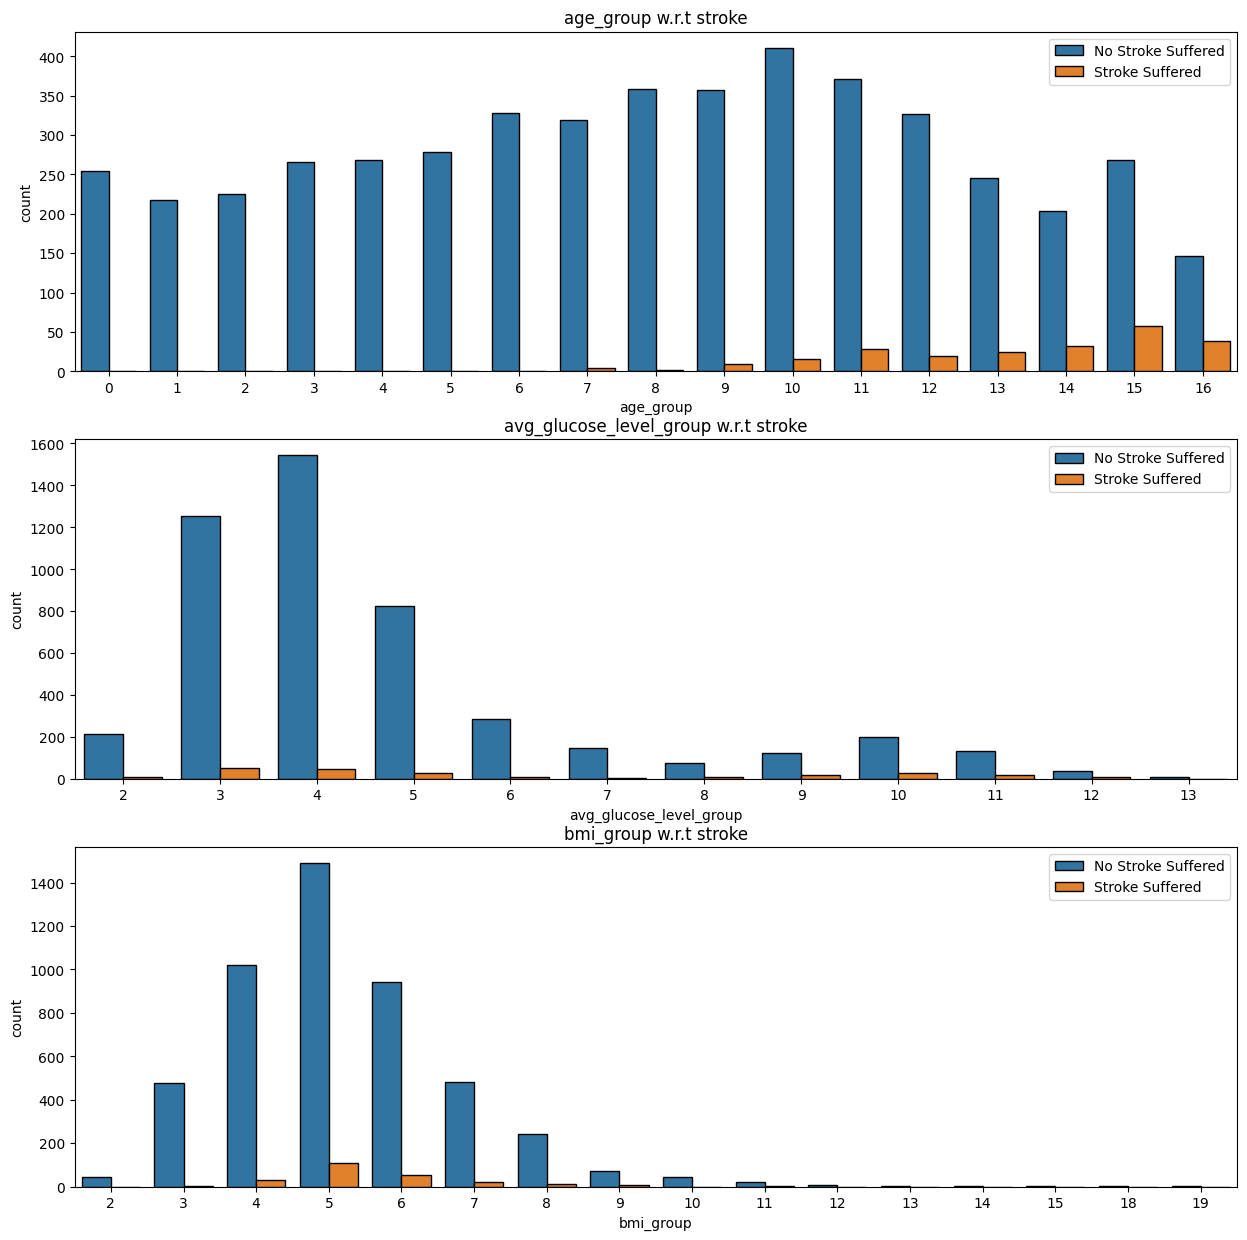

In [ ]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
group_numerical_features = [i + '_group' for i in ['age','avg_glucose_level','bmi']]

for i in range(len(group_numerical_features)):
    plt.subplot(3,1,i+1)
    sns.countplot(x=group_numerical_features[i],data = data1,hue = "stroke",edgecolor = 'black')
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'] ,loc = 'upper right')
    title = group_numerical_features[i] + ' w.r.t stroke'
    plt.title(title)

In [ ]:
data1 = data1.drop(columns=['age_group', 'avg_glucose_level_group', 'bmi_group'])

In [ ]:
categorical_features.remove('stroke')

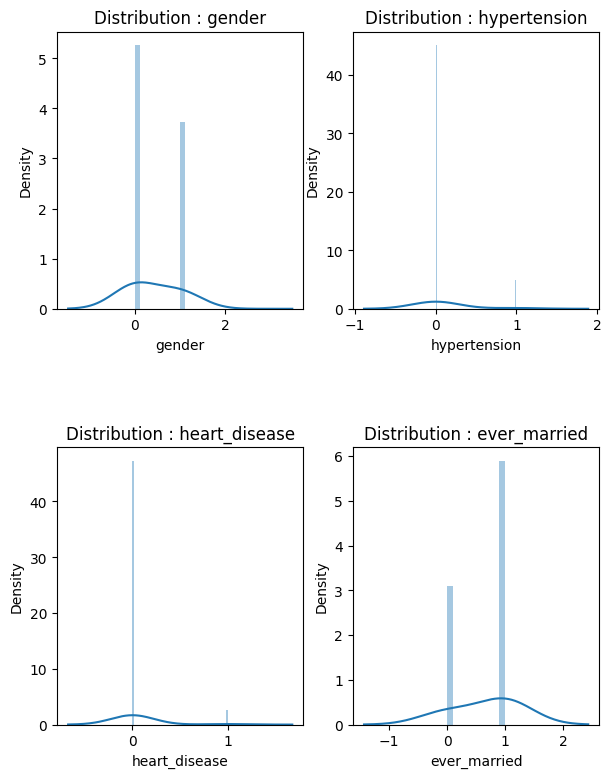

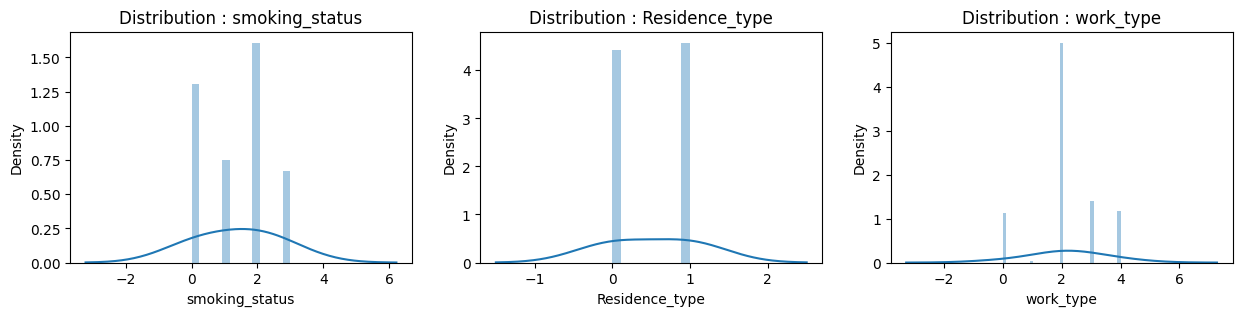

In [ ]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (7,9))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(len(categorical_features[:4])):
    plt.subplot(2,2,i+1)
    sns.distplot(data1[categorical_features[i]],kde_kws = {'bw' : 1});
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,3))
for i in range(-1,-4,-1):
    plt.subplot(1,3,-i)
    sns.distplot(data1[categorical_features[i]],kde_kws = {'bw' : 1});
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

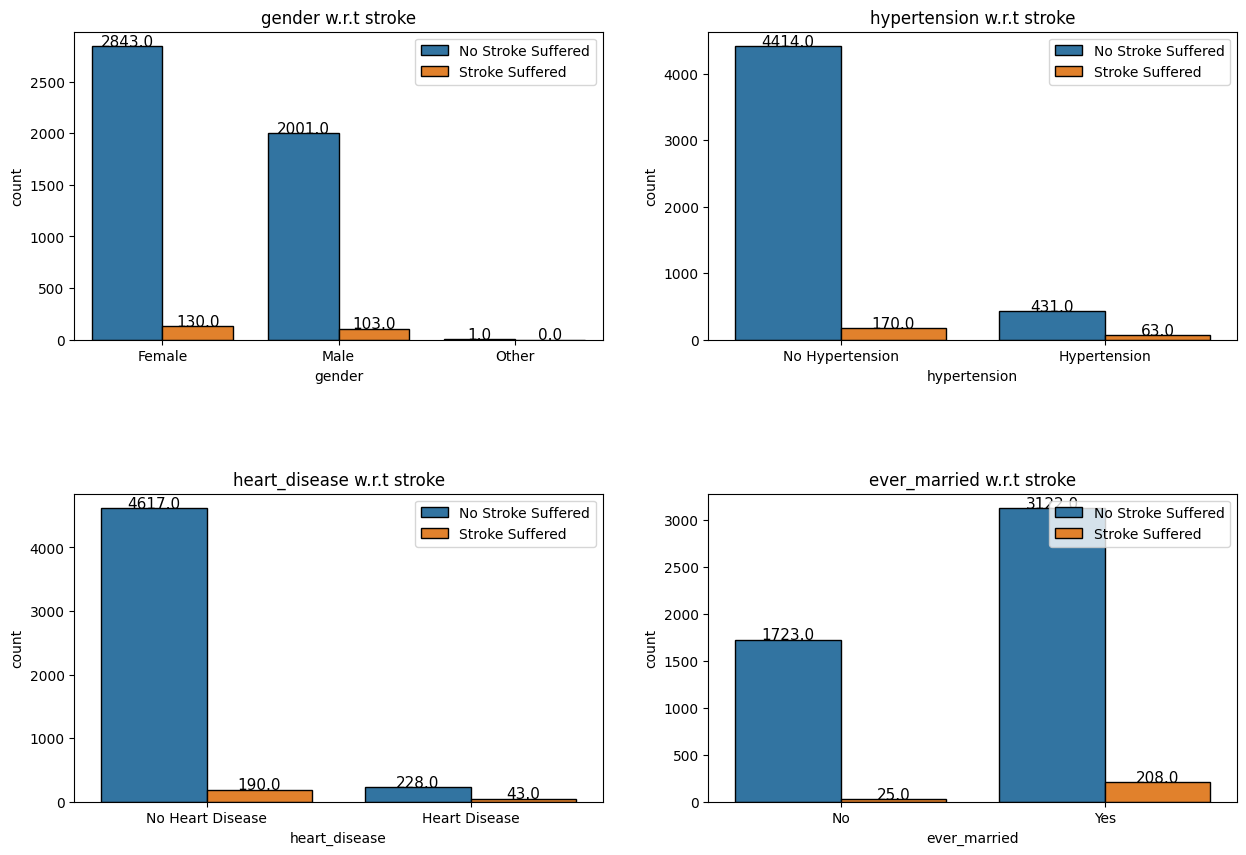

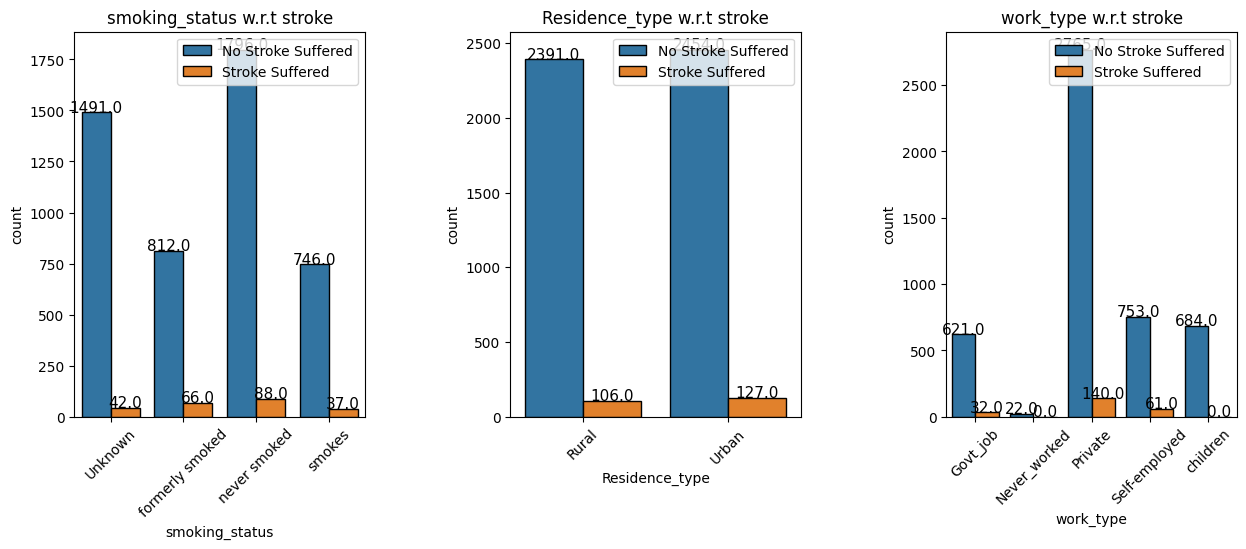

In [ ]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x=categorical_features[i],data = data1,hue = "stroke",edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    ax.set_xticklabels([tf1[categorical_features[i]][j] for j in sorted(data1[categorical_features[i]].unique())])
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'], loc = 'upper right')
    title = categorical_features[i] + ' w.r.t stroke'
    plt.title(title);

fig = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(-1,-4,-1):
    plt.subplot(1,3,-i)
    ax = sns.countplot(x=categorical_features[i],data = data1,hue = "stroke",edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    ax.set_xticklabels([tf1[categorical_features[i]][j] for j in sorted(data1[categorical_features[i]].unique())])
    plt.legend(['No Stroke Suffered', 'Stroke Suffered'], loc = 'upper right')
    title = categorical_features[i] + ' w.r.t stroke'
    plt.title(title)
    plt.xticks(rotation=45)

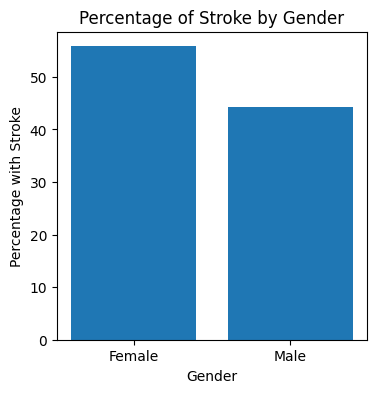

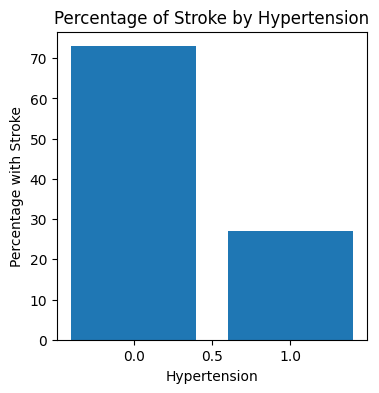

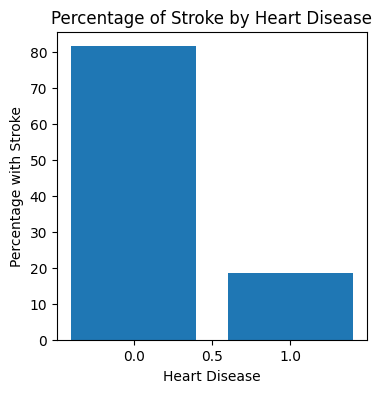

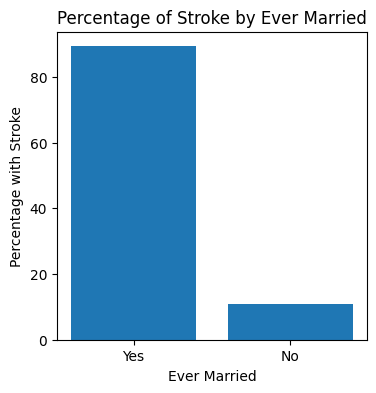

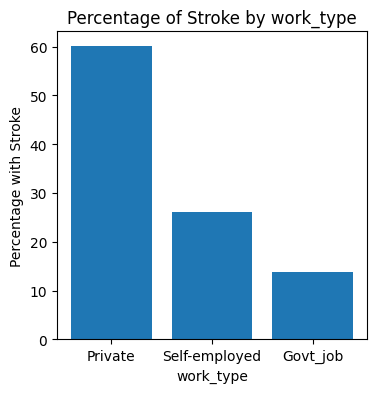

In [ ]:
plt.figure(figsize=(4, 4))
plt.bar(gender_stroke.index, gender_stroke.values)
plt.xlabel('Gender')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Gender')
plt.show()

# Bar graph for 'hypertension'
plt.figure(figsize=(4, 4))
plt.bar(hypertension_stroke.index, hypertension_stroke.values)
plt.xlabel('Hypertension')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Hypertension')
plt.show()

# Bar graph for 'heart_disease'
plt.figure(figsize=(4, 4))
plt.bar(heart_disease_stroke.index, heart_disease_stroke.values)
plt.xlabel('Heart Disease')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Heart Disease')
plt.show()

# Bar graph for 'ever_married'
plt.figure(figsize=(4, 4))
plt.bar(ever_married_stroke.index, ever_married_stroke.values)
plt.xlabel('Ever Married')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Ever Married')
plt.show()

# Bar graph for 'work_type"
plt.figure(figsize=(4, 4))
plt.bar(work_type_stroke.index, work_type_stroke.values)
plt.xlabel('work_type')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by work_type')
plt.show()

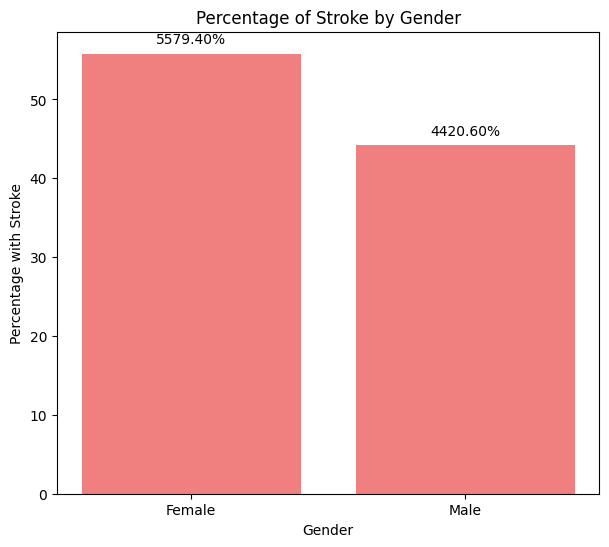

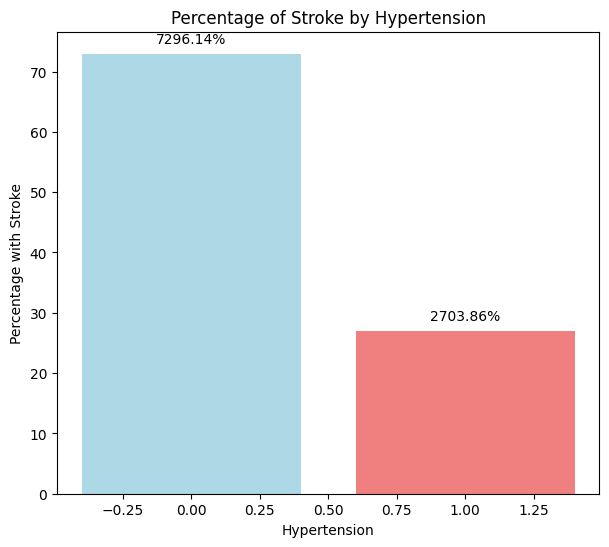

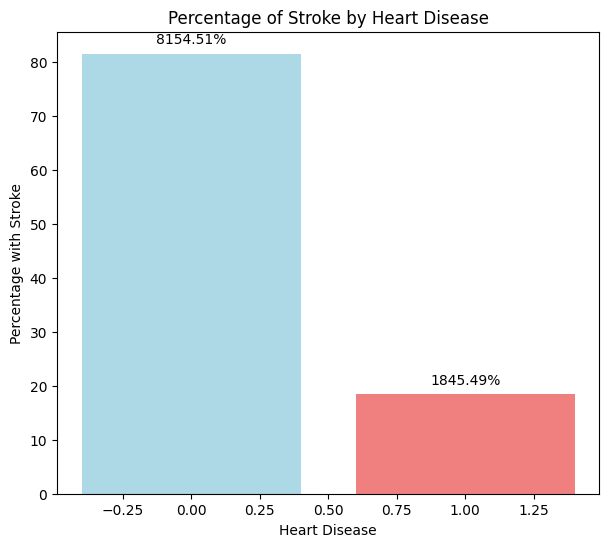

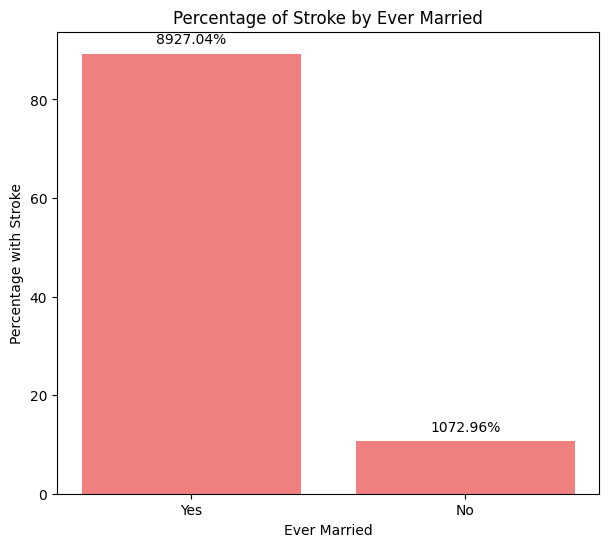

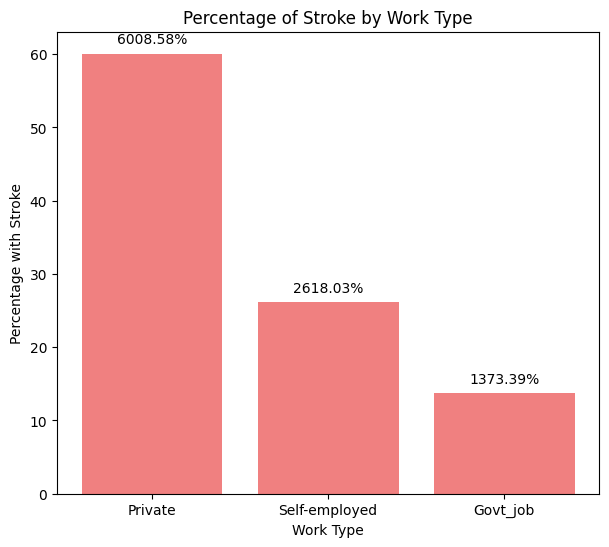

In [ ]:
import matplotlib.pyplot as plt

# Function to add labels to each bar
def add_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Bar graph for 'gender'
plt.figure(figsize=(7, 6))
gender_colors = ['lightblue' if value == 0 else 'lightcoral' for value in gender_stroke.index]
ax1 = plt.bar(gender_stroke.index, gender_stroke.values, color=gender_colors)
plt.xlabel('Gender')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Gender')
add_labels(plt.gca())
plt.show()

# Bar graph for 'hypertension'
plt.figure(figsize=(7, 6))
hypertension_colors = ['lightblue' if value == 0 else 'lightcoral' for value in hypertension_stroke.index]
ax2 = plt.bar(hypertension_stroke.index, hypertension_stroke.values, color=hypertension_colors)
plt.xlabel('Hypertension')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Hypertension')
add_labels(plt.gca())
plt.show()

# Bar graph for 'heart_disease'
plt.figure(figsize=(7, 6))
heart_disease_colors = ['lightblue' if value == 0 else 'lightcoral' for value in heart_disease_stroke.index]
ax3 = plt.bar(heart_disease_stroke.index, heart_disease_stroke.values, color=heart_disease_colors)
plt.xlabel('Heart Disease')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Heart Disease')
add_labels(plt.gca())
plt.show()

# Bar graph for 'ever_married'
plt.figure(figsize=(7, 6))
ever_married_colors = ['lightblue' if value == 0 else 'lightcoral' for value in ever_married_stroke.index]
ax4 = plt.bar(ever_married_stroke.index, ever_married_stroke.values, color=ever_married_colors)
plt.xlabel('Ever Married')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Ever Married')
add_labels(plt.gca())
plt.show()

# Bar graph for 'work_type'
plt.figure(figsize=(7, 6))
work_type_colors = ['lightblue' if value == 0 else 'lightcoral' for value in work_type_stroke.index]
ax5 = plt.bar(work_type_stroke.index, work_type_stroke.values, color=work_type_colors)
plt.xlabel('Work Type')
plt.ylabel('Percentage with Stroke')
plt.title('Percentage of Stroke by Work Type')
add_labels(plt.gca())
plt.show()
